# Imported Libraries

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils
import pickle

In [0]:
#!pip install utils

In [0]:
from importlib import reload
import utils; reload(utils)
from utils import *
import glob
import colorsys

ModuleNotFoundError: ignored

#Calibration of Camera

##Supporting class for calibration


In [0]:
class ChessBoard:

  def __init__(self, test_number, test_file, x_boxes, y_boxes):
    self.test_number = test_number
    self.test_file = test_file
    self.x_boxes, self.y_boxes = x_boxes, y_boxes
    self.chess_matrix = (self.x_boxes, self.y_boxes)  # chess board variables initialization 

    read_img = mpimg.imread(self.test_file)
    grey_img = cv2.cvtColor(read_img, cv2.COLOR_RGB2GRAY)  # read file and grayscale it
    
    self.rows, self.col, self.channels = read_img.shape   #set dimensions according to orginal pictures
    self.dimensions = (self.rows, self.col)

    self.has_corners, self.corners = cv2.findChessboardCorners(grey_img,self.chess_matrix, None) # get corners using cv2 function
    self.chessboard_points = self.get_points()
    self.matrix, self.distortion, self.can_undistort = None, None, False
  
  def get_points(self):
    number_of_points = self.x_boxes * self.y_boxes
    points = np.zeros((number_of_points, 3), np.float32)
    points[:, :2] = np.mgrid[0:self.x_boxes, 0:self.y_boxes].T.reshape(-1, 2)
    return points

  # remove if not used  
  def image(self):
    read_img = mpimg.imread(self.test_file)
    return read_img

  def image_with_corners(self):
    ''' if this image doesn't have calculated corners, return raw image '''
    read_img = mpimg.imread(self.test_file)
    if self.has_corners:
      cv2.drawChessboardCorners(read_img, self.chess_matrix, self.corners, self.has_corners)
    return read_img

  def undistorted_image(self):
    '''if camera parameters is not initialized, return None '''
    read_img = None
    if self.can_undistort:
      read_img = mpimg.imread(self.test_file)
      read_img = cv2.undistort(read_img, self.matrix, self.distortion, None, self.matrix)
    return read_img
  
  def load_undistort_params(self, camera_matrix, distortion):
    self.distortion = distortion
    self.matrix = camera_matrix
    self.can_undistort = True

In [0]:
#initializing chessboards

chessboards = []
path = "1.jpeg"

for n in range(20):
  # add path for 20 different angles of the chessboard here
  chessboard = ChessBoard(test_number=n, test_file = path, x_boxes=9, y_boxes=6)
  chessboards.append(chessboard)

print("done")


In [0]:
# finding calibration parameters

points, corners = [], [],  #list for point and corners
shape = chessboards[0].dimensions

for chessboard in chessboards:
  if chessboard.has_corners:
    points.append(chessboard.object_points)
    corners.append(chessboard.corners)

# will work with actual chessboard pics
r, matrix, dist_coef, rv, tv = cv2.calibrateCamera(points, corners, shape, None, None)


In [0]:
# store calibration parameters for later

calibration_parameters = {"camera_matrix": matrix, "dist_coef": dist_coef}
pickle.dump(calibration_parameters, open("calibration_parameters", "wb"))

In [0]:
# get an undistorted picture\

for chessboard in chessboards:
  chessboard.load_undistort_params(calibration_matrix = matrix, distortion = dist_coef)

In [0]:
#save imgs

for chessboard in chessboards:
  if chessboard.has_corners:
    save_image(chassboard.image_with_corners, "corners", chessboard.test_number)
  
  if chessboard.can_undistort:
    save_image(chessboard.undistorted_image(), "undistortedboard", chessboard.test_number)

# Perspective Transformation

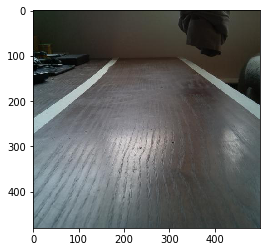

In [0]:
IMAGE_H = 480
IMAGE_W = 360

img = mpimg.imread("1.jpeg")
src = np.float32([[170, 100], [350, 100], [500, 220], [0, 220]])
dst = np.array([[0, img.shape[0]], [0, 0], [500, 0], [500, img.shape[0]]], np.float32)
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

plt.imshow(img, cmap='gray')
plt.show()

#Warp Perspective

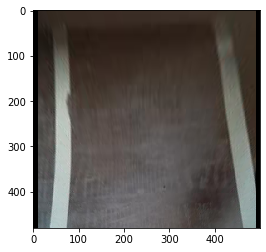

In [0]:
result = cv2.warpPerspective(img, M,(500,480), flags=cv2.INTER_LINEAR)
rotated = imutils.rotate(result, 270)
edges = cv2.Canny(rotated, 20,100)
plt.imshow(rotated, cmap='gray')
plt.show()


#Crop Image

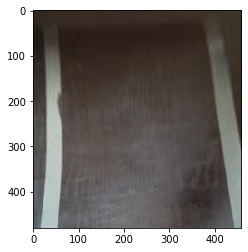

In [0]:
cropped_image = rotated[0:480, 20:480]
plt.imshow(cropped_image, cmap='gray')
plt.show()

edges = cv2.Canny(cropped_image, 20,100)

#Draw corners of trapazoid to be extracted 

In [0]:
#cv2.circle(img, (120, 150), 10, (0,0,255), -1)
#cv2.circle(img, (420, 150), 10, (0,0,255), -1)
#cv2.circle(img, (600, 250), 10, (0,0,255), -1)
#cv2.circle(img, (-100, 250), 10, (0,0,255), -1)

#Show orginal images with trapazoid that is being extracted and the transformed image

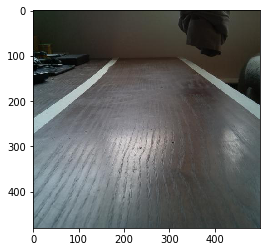

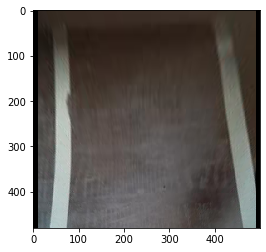

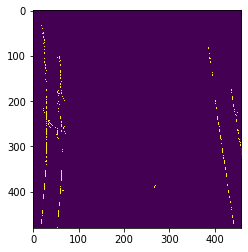

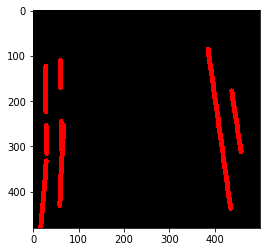

In [0]:

plt.imshow(img)
plt.show()
plt.imshow(rotated)
plt.show()
plt.imshow(edges)
plt.show()

lines = cv2.HoughLinesP(edges, 2,np.pi/180,
                        100,
                        np.array([]),
                        minLineLength=40,
                        maxLineGap=50)
line_img = np.zeros_like(img)

def draw_lines(img, lines):

    if lines is not None:
      for line in lines:
        x1,y1,x2,y2 =  line.reshape(4)
        cv2.line(line_img, (x1, y1), (x2,y2), (255, 0, 0), 10)
    return line_img
 
line_img = draw_lines(line_img, lines)
plt.imshow(line_img)
plt.show()

#height = img.shape[0]
#width = img.shape[1]
#print(height, width)    


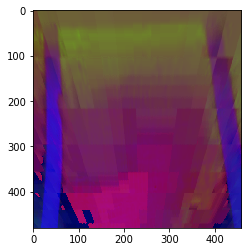

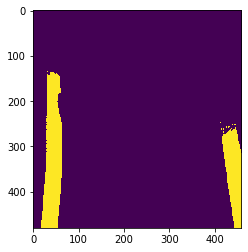

In [0]:
#img = cv2.imread('shuttle.jpg')   # you can read in images with opencv
img_hsv = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

lower_blue = np.array([125,125,125]) #change values here. not good
upper_blue = np.array([255,255,255])

mask = cv2.inRange(cropped_image, lower_blue, upper_blue)
plt.imshow(img_hsv, cmap='gray') 
plt.show()
plt.imshow(mask)  
plt.show()
    

#Drawing a Histogram

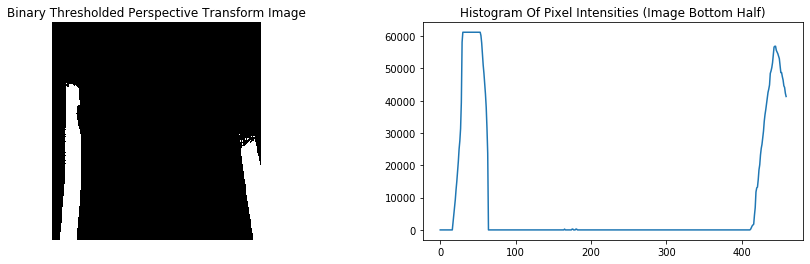

In [0]:
histogram = np.sum(mask[edges.shape[0]//2:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(mask, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

# Done Getting Histogram

http://faculty.washington.edu/cfolson/papers/pdf/cviu99.pdf
https://towardsdatascience.com/deeppicar-part-4-lane-following-via-opencv-737dd9e47c96
https://www.hackster.io/kemfic/curved-lane-detection-34f771

